# GaussianSimulationSolver

Generate random realisations from a given covariance matrix

In [1]:
import numpy as np
import meshio
import os
import sys

import xugrid as xu
import xarray as xr

import shapely
import matplotlib.pyplot as plt

import skgstat as skg
import gstools as gs

#https://gricad-gitlab.univ-grenoble-alpes.fr/gilletcf/elmerugrid
sys.path.insert(0, os.path.abspath('../../elmerugrid'))
from ElmerUgrid import ugrid
from ElmerUgrid.fem import TriIntegrate
from ElmerUgrid.Interpolation import *

## Analitical correlation functions

In [2]:
import scipy
def matern(l, r, nu):
    """Computes Matérn correlation function for given distances and parameters
    Parameters:
    -----------
    l : array
        Distances between locations.
    r : float
        Range parameter. Must be greater than 0.
    nu : float
        Smoothness parameter. Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    assert r > 0
    assert nu > 0
    eps=np.finfo(np.float32).eps
    d=np.where( l == 0.0,eps,l)
    a = (2**(nu - 1) * scipy.special.gamma(nu))**(-1)
    b = (d / r)**nu * scipy.special.kv(nu, d / r)
    return a * b

def gaussian(l, r):
    """Computes gaussian correlation function for given distances and range
    Parameters:
    -----------
    l : array
        Distances between locations.
    r : float
        Range parameter. Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    assert r > 0
    eps=np.finfo(np.float32).eps
    d=np.where( l == 0.0,eps,l)
    out=np.exp(-d**2/(2*r**2))
    return out

### Parameters for the test case:

In [3]:
#case ID
ID=3
# Covariance parameters
range_l=2000.0
nu=1.0
sill=100

#mesh name
mesh_name="rectangle"

# number of realisations in total
nread=100

### Read the results

In [4]:
#get the grid
elmer_grid=xu.Ugrid2d.FromElmer(mesh_name)

# read all vtus
res=np.zeros((elmer_grid.n_node,nread))
for ii in range(nread):
    result=meshio.read(os.path.join(mesh_name,"Gaussian_%s_t%s.vtu"%(str(ID),str(ii+1).zfill(4))))
    res[:,ii]=result.point_data['r'][:,0]

## convert to data array
result_da=xu.UgridDataArray(
       xr.DataArray(
         data=res,
         name="field",
         dims=[elmer_grid.node_dimension,"cases"],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)

## compute ensemble mean and std
ens_mean=np.mean(res, axis=1)
ens_std=np.std(res,axis=1)

mean_da=xu.UgridDataArray(
       xr.DataArray(
         data=ens_mean,
         name="mean",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)

std_da=xu.UgridDataArray(
       xr.DataArray(
         data=ens_std,
         name="std",
         dims=[elmer_grid.node_dimension],
         attrs=dict(mesh=elmer_grid.name,location="node")),
      elmer_grid)




### Plot some results

plot the first 4 members and the ensemble mean (should converge to the prescribed mean value, i.e. 0 here) and std (should converge to the prescribed std, i.e. 100 here)

As expected for the "diffusion operator" method, the variance should overestimated near the boundaries, especially the corners.

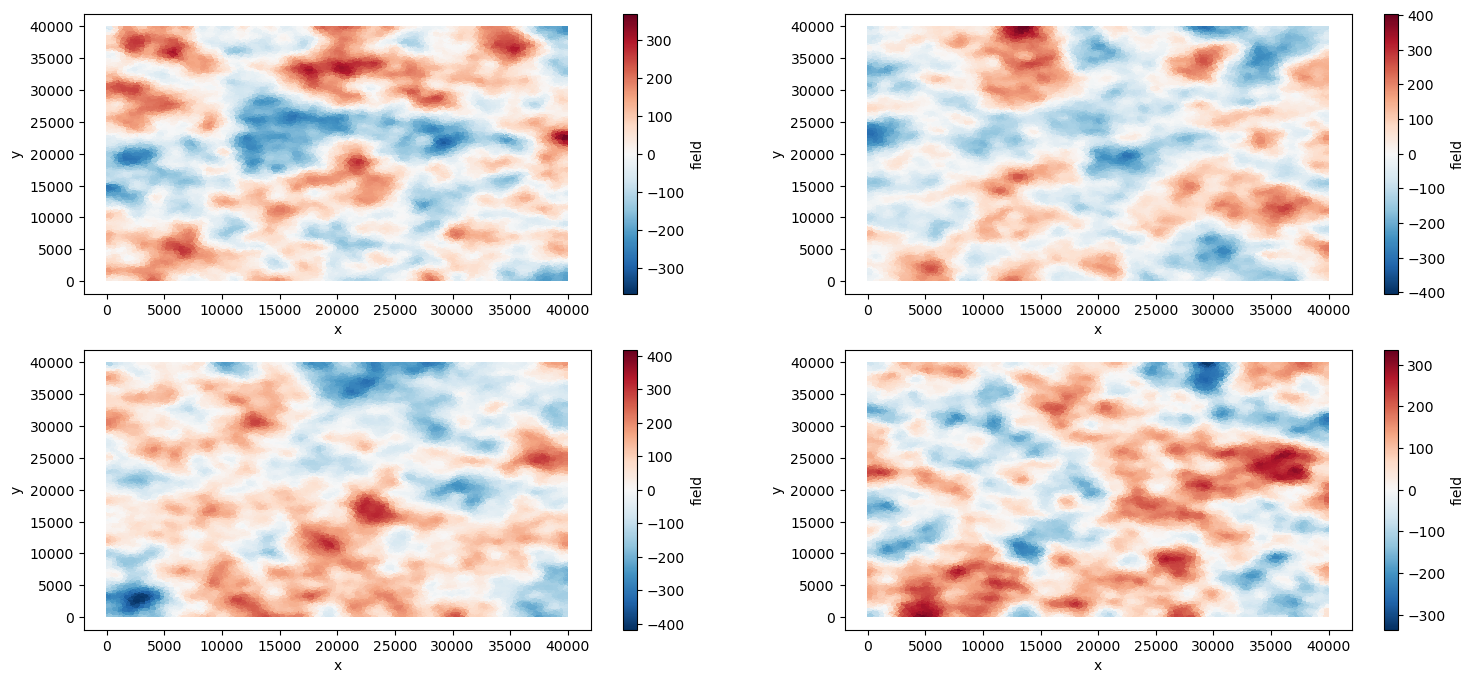

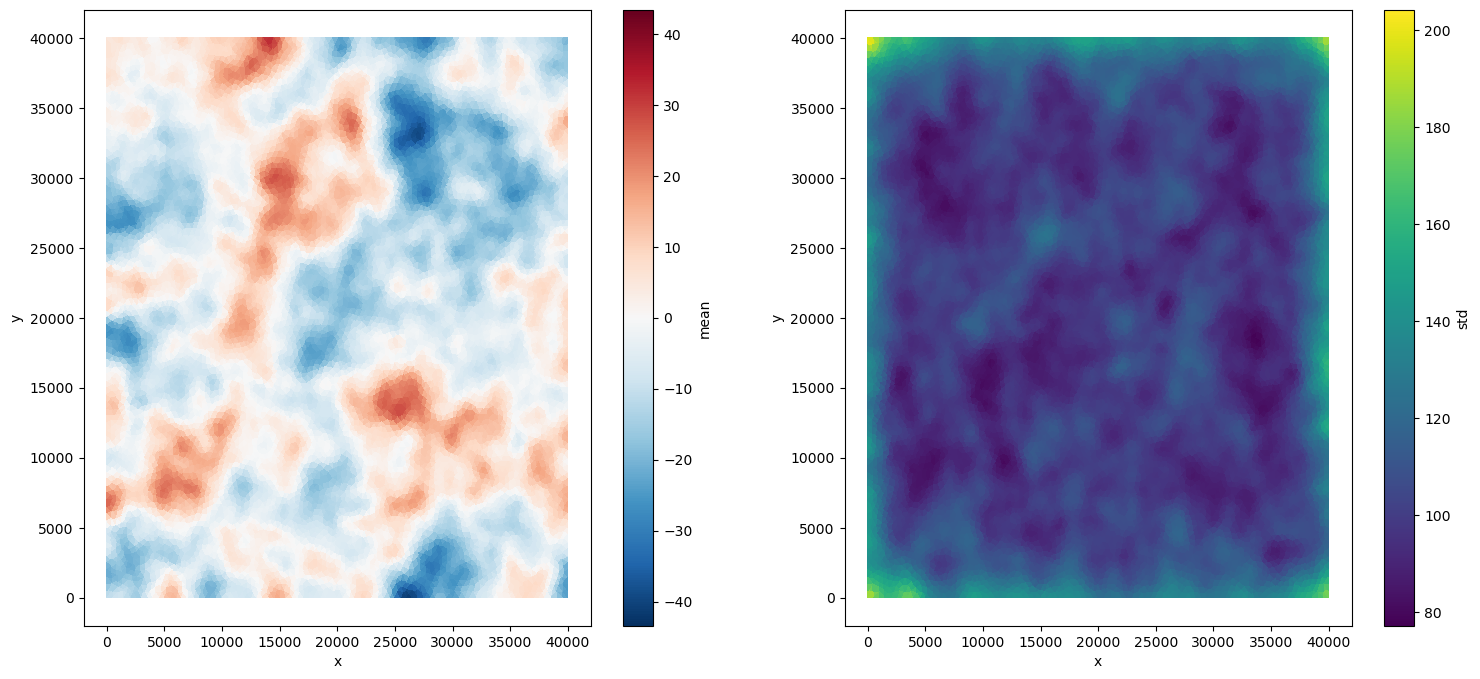

In [5]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(18, 8))
result_da.isel(cases=1).ugrid.plot(ax=ax1)
result_da.isel(cases=2).ugrid.plot(ax=ax2)
result_da.isel(cases=3).ugrid.plot(ax=ax3)
result_da.isel(cases=4).ugrid.plot(ax=ax4)

fig, (ax5,ax6)= plt.subplots(ncols=2,figsize=(18, 8))
mean_da.ugrid.plot(ax=ax5)
std_da.ugrid.plot(ax=ax6)

### Plot some profils

In [6]:
nplot=5

(8574, 100)


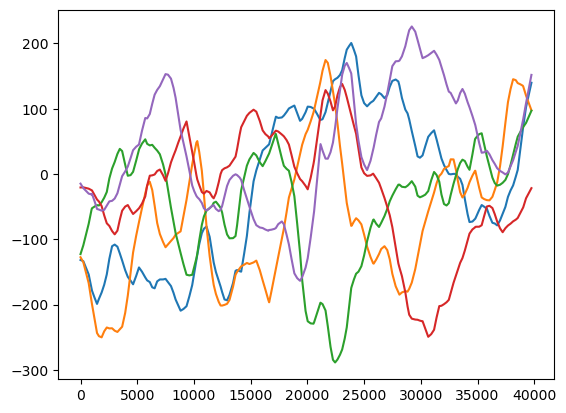

In [7]:
area= xu.UgridDataArray(
       xr.DataArray(
         data=elmer_grid.area,
         name="area",
         dims=[elmer_grid.face_dimension],
         attrs=dict(mesh=elmer_grid.name,location="face")),
      elmer_grid)

# extract line y=20.0e3
line = area.ugrid.sel(y=20.0e3)
axis_name=area.grid.name+"_s"

## Baricentric interpolation at the given points
points=np.vstack((line.mesh2d_x.values,line.mesh2d_y.values)).T

M,out = barycentric_interpolator(points, elmer_grid)
print(np.shape(result_da.values))

ax = plt.subplot()

for ii in range(nplot):
    interp=M*result_da.values[:,ii]
    interp[out]=np.nan
    ax.plot(line[axis_name].values,interp)

#plt.plot(line[axis_name].values,out,color="blue") 
plt.show()

### Plot the analytical variogram

/home/gilletcf/anaconda3/envs/xugrid/lib/python3.12/site-packages/gstools/covmodel/plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


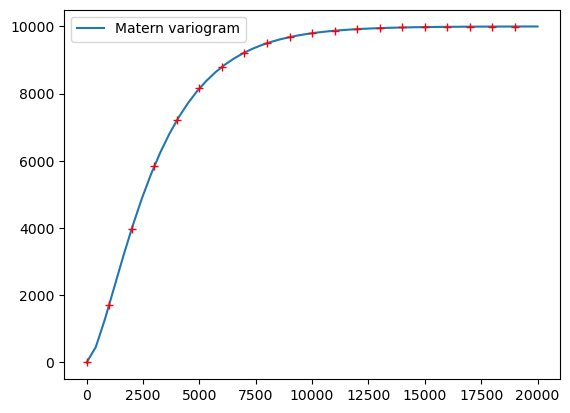

In [8]:
d=np.arange(0,20.0e3,1.0e3)

# the analytical function
correlation=matern(d,range_l,nu)
gamma=(sill**2)*(1.0-correlation)

# get the equivalent from gstol
mat=gs.Matern(dim=2,len_scale=range_l,nugget=0.0,nu=nu,var=sill**2)
ax = plt.subplot()
mat.plot(ax=ax,x_max=20.0e3)
ax.plot(d,gamma,'+r')

### Compare the sampled variograms with the prescribed variograms

gstool seems to be very slow to compute the variograms... and Matern implementation in skg do not seems to be correct. to check.

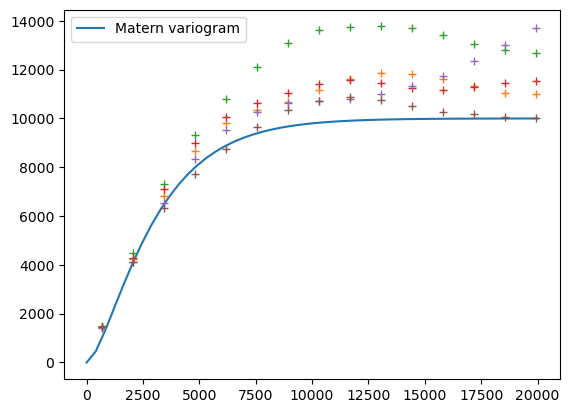

In [9]:
effective_range=3*range_l

ax = plt.subplot()
mat.plot(ax=ax,x_max=20.0e3)

for ii in range(nplot):
    V = skg.Variogram(elmer_grid.node_coordinates, result_da.values[:,ii],model="matern", maxlag='median', n_lags=15, normalize=False,fit_method='manual',fit_shape=nu,fit_sill=sill**2,fit_range=effective_range,fit_nugget=0.0)
    bins,experimental=V.get_empirical(bin_center=True)
    ax.plot(bins,experimental,"+")

plt.show()